In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LayerNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.regularizers import l2

In [2]:
normal_path = 'OralCancer/Normal'
oscc_path = 'OralCancer/OSCC'

In [3]:
def load_images(folder_path, label, image_size=(128, 128)):
    images, labels = [], []
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load Normal and OSCC images
normal_images, normal_labels = load_images(normal_path, label=0)
oscc_images, oscc_labels = load_images(oscc_path, label=1)

In [4]:
images = np.concatenate((normal_images, oscc_images), axis=0)
labels = np.concatenate((normal_labels, oscc_labels), axis=0)

In [5]:
# Normalize images
images = images / 255.0
# One-hot encode labels
labels = to_categorical(labels, num_classes=2)

In [6]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=97, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=97, stratify=y_temp)

In [7]:
model = Sequential([
    # Convolutional Block 1
    Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate= 0.3, seed= 123),

    # Convolutional Block 2
    Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate= 0.3, seed= 123),

    # MaxPooling (Final Pooling Layer)
    MaxPooling2D(pool_size=2, strides=2),
    # Flatten the output for Dense Layers
    Flatten(),

    # Dense Layers
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)       

In [8]:
print(X_train.shape)
print(y_train.shape)

(3462, 128, 128, 3)
(3462, 2)


In [47]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('kan_oralcancer_model1.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
55/55 [==============================] - 13s 222ms/step - loss: 0.3934 - accuracy: 0.8795 - val_loss: 1.0713 - val_accuracy: 0.6549
Epoch 2/100
55/55 [==============================] - 12s 219ms/step - loss: 0.4340 - accuracy: 0.8408 - val_loss: 0.6883 - val_accuracy: 0.7626
Epoch 3/100
55/55 [==============================] - 12s 218ms/step - loss: 0.4146 - accuracy: 0.8599 - val_loss: 0.6532 - val_accuracy: 0.7757
Epoch 4/100
55/55 [==============================] - 12s 218ms/step - loss: 0.4108 - accuracy: 0.8637 - val_loss: 0.6848 - val_accuracy: 0.7404
Epoch 5/100
55/55 [==============================] - 12s 219ms/step - loss: 0.4050 - accuracy: 0.8712 - val_loss: 0.8230 - val_accuracy: 0.7173
Epoch 6/100
55/55 [==============================] - 12s 218ms/step - loss: 0.4135 - accuracy: 0.8628 - val_loss: 0.5596 - val_accuracy: 0.7948
Epoch 7/100
55/55 [==============================] - 12s 218ms/step - loss: 0.4941 - accuracy: 0.8267 - val_loss: 2.7589 - val_accuracy:

In [49]:
#Load saved model

from tensorflow.keras.models import load_model
model = load_model('kan_oralcancer_model1.keras')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_3 (Bat  (None, 64, 64, 64)       

In [50]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 [==============================] - 1s 27ms/step - loss: 0.3097 - accuracy: 0.9245
Test Loss: 0.30967360734939575
Test Accuracy: 0.9244897961616516


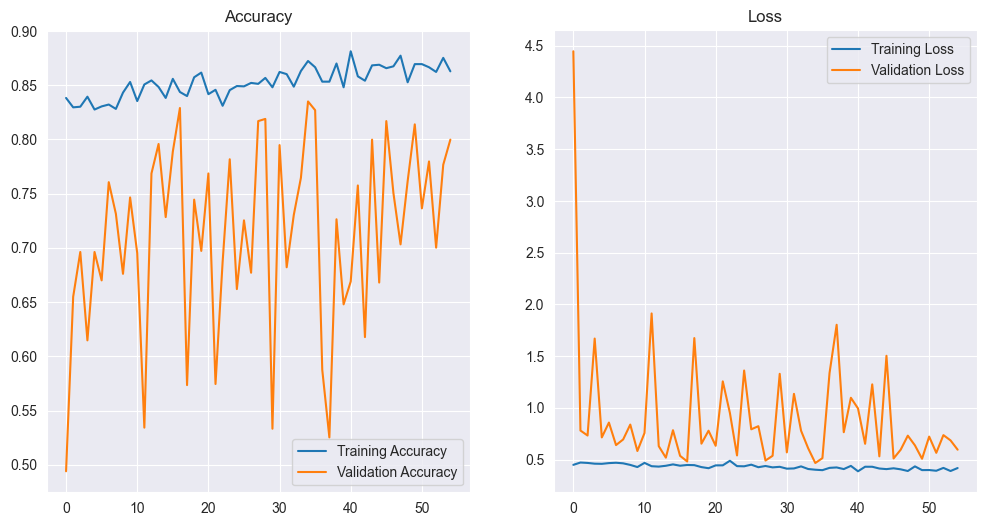

In [44]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

16/16 [==============================] - 1s 29ms/step


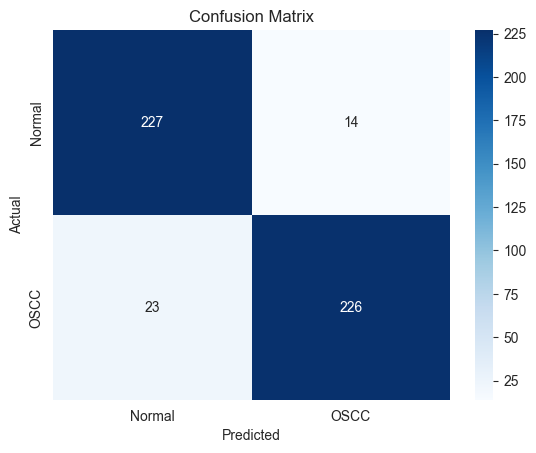

In [51]:
# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'OSCC']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [52]:
tn, fp, fn, tp = cm.ravel()
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = tn / (tn + fp)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"True Positive: {tp}")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")

Accuracy: 0.9245
Precision: 0.9417
Recall (Sensitivity): 0.9076
Specificity: 0.9419
F1 Score: 0.9243
True Positive: 226
True Negative: 227
False Positive: 14
False Negative: 23
